In [42]:
from xlib.mysql import mysql
import json
ts_code='002624.sz'


#获取同行列表
def getSameList(ts_code):
    industry=mysql.selectToDf('select industry from astock_basic where ts_code="'+ts_code+'"','tushare')
    industry=industry['industry'].values[0]
    same_list=mysql.selectToDf('select ts_code from astock_basic where industry="'+industry+'"','tushare')
    same_list=same_list['ts_code'].to_list()
    return same_list


print(getSameList(ts_code))

['000156.SZ', '000665.SZ', '000673.SZ', '000802.SZ', '000835.SZ', '000892.SZ', '000917.SZ', '002238.SZ', '002292.SZ', '002343.SZ', '002445.SZ', '002502.SZ', '002624.SZ', '002699.SZ', '002739.SZ', '002905.SZ', '300027.SZ', '300133.SZ', '300182.SZ', '300251.SZ', '300291.SZ', '300336.SZ', '300413.SZ', '300426.SZ', '300528.SZ', '300770.SZ', '600037.SH', '600052.SH', '600088.SH', '600136.SH', '600576.SH', '600637.SH', '600640.SH', '600715.SH', '600831.SH', '600892.SH', '600936.SH', '600959.SH', '600977.SH', '600996.SH', '601595.SH', '601929.SH', '603103.SH', '603598.SH', '603721.SH']


In [40]:
#获取股票信息
def getStockInfo(ts_code):
    basic_info=mysql.selectToDf('select * from astock_basic where ts_code="'+ts_code+'"','tushare')
    company_info=mysql.selectToDf('select * from astock_stock_company where ts_code="'+ts_code+'"','tushare')
    stock_info={
        'name':basic_info['name'].values[0],
        'fullname':basic_info['fullname'].values[0],
        'office':company_info['office'].values[0],
        'industry':basic_info['industry'].values[0],
        'market':basic_info['market'].values[0],
        'introduction':company_info['introduction'].values[0],
        'business_scope':company_info['business_scope'].values[0],
        'main_business':company_info['main_business'].values[0]
    }
    return stock_info

print(json.dumps((getStockInfo(ts_code)), indent=4, ensure_ascii=False))

{
    "name": "完美世界",
    "fullname": "完美世界股份有限公司",
    "office": "北京市朝阳区望京东路1号院4号楼完美世界A座",
    "industry": "影视音像",
    "market": "中小板",
    "introduction": "公司是中国大型的影游综合体，业务涵盖完美世界影视和完美世界游戏两大板块，包括：网络游戏的研发、发行和运营；电视剧、电影的制作、发行及衍生业务；综艺娱乐业务；艺人经纪服务及相关服务业务。公司影视作品荣获多项国内外知名奖项，其中包括电视剧飞天奖、白玉兰奖、华鼎奖，电影华表奖、大众电影百花奖、金马奖等。　作为中国最早进行海外运营的网络游戏公司，完美世界游戏在中国网络游戏海外出口市场收入中连续多年排名第一，用户群体覆盖至全球100多个国家和地区，在全球建立了自己的运营平台。",
    "business_scope": "广播电视节目制作经营(范围详见《广播电视节目制作经营许可证》)。动漫、平面设计、制作，网站开发，网页设计，设计、制作、代理、发布国内各类广告，软件开发、销售，文化艺术活动、体育赛事、企业营销的策划，休闲观光旅游项目开发，会展服务，企业管理咨询，教育咨询，投资管理，投资咨询，资产管理，服装、玩具、鞋帽、箱包、眼镜、首饰、文化用品、电子产品、日用杂货、针织纺品、工艺品、通讯设备、花草、观赏性植物、计算机及辅助设备的销售，从事进出口业务。(依法须经批准的项目，经相关部门批准后方可开展经营活动)",
    "main_business": "电视剧(开发/制作/营销发行),电影(开发/制作/营销发行),综艺栏目,艺人经纪,商务广告,衍生经济及其他等各个影视业务板块."
}


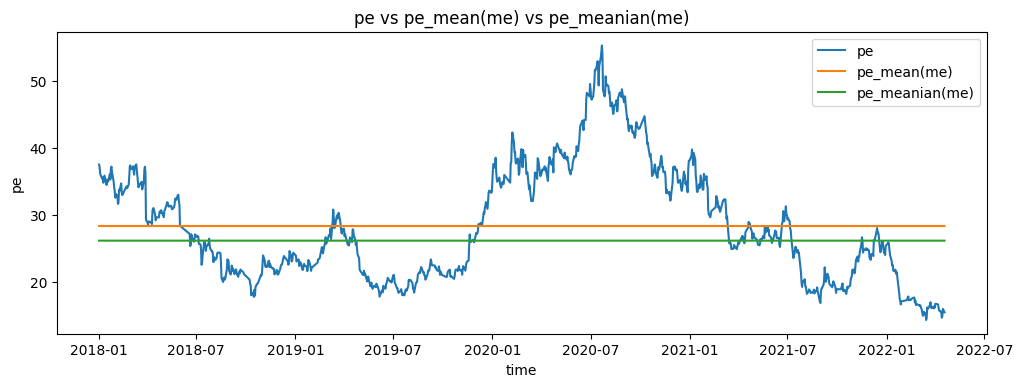

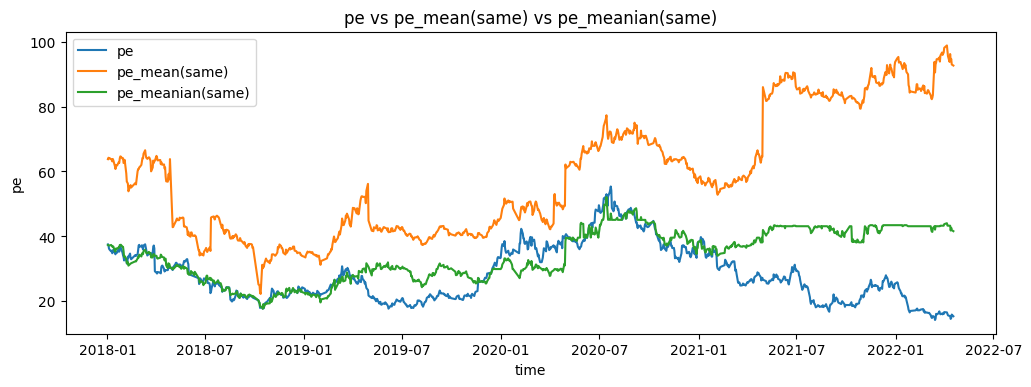

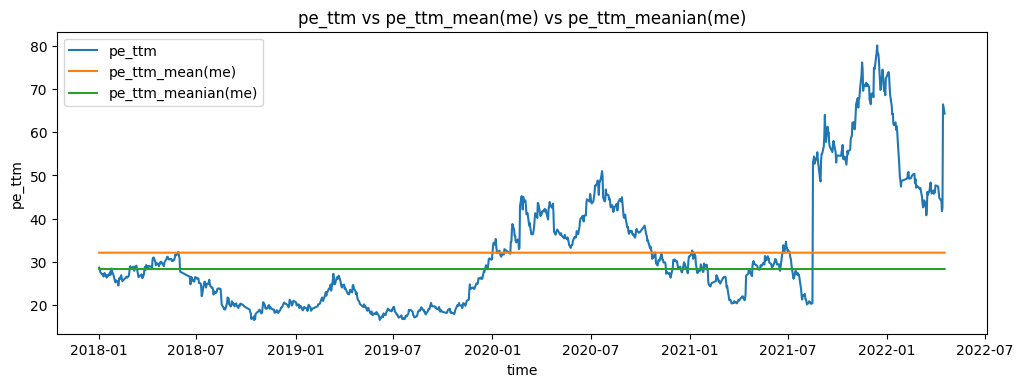

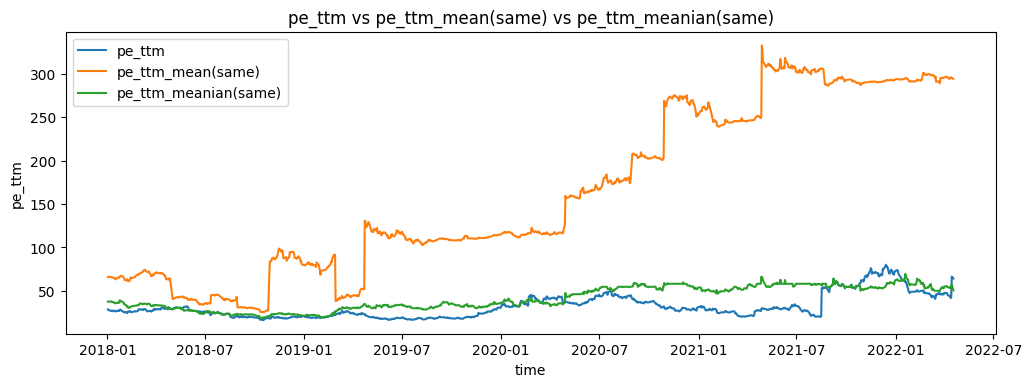

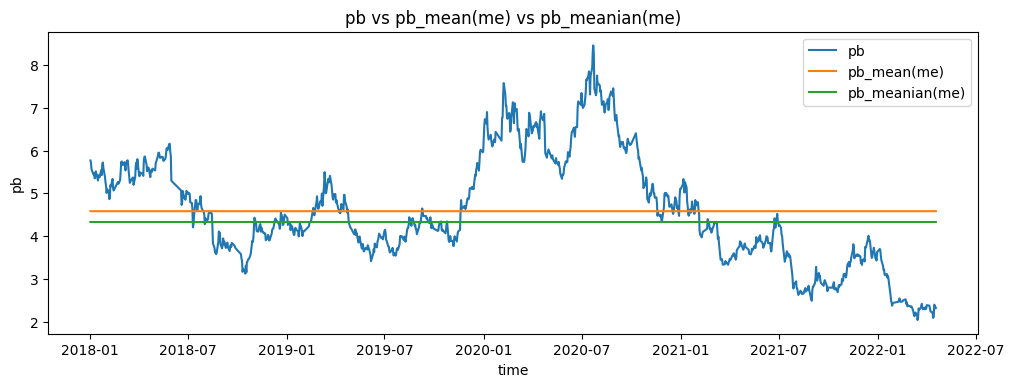

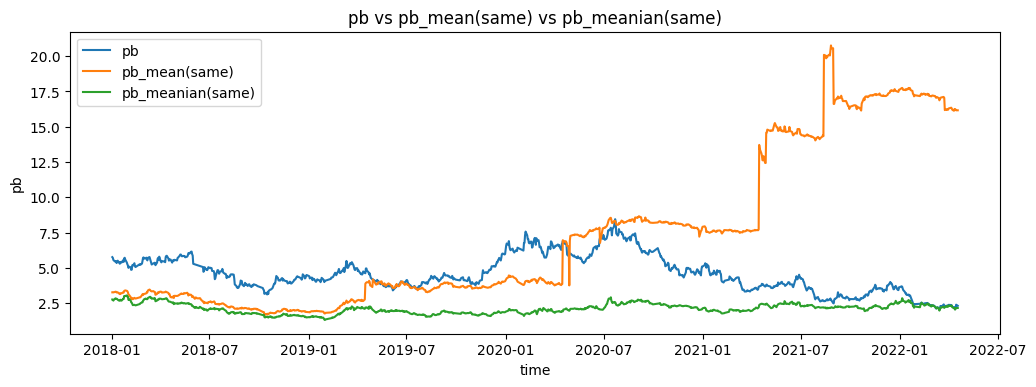

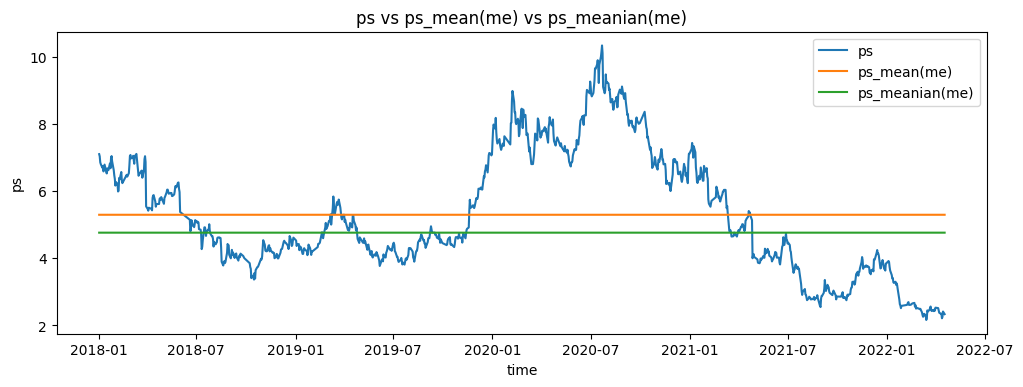

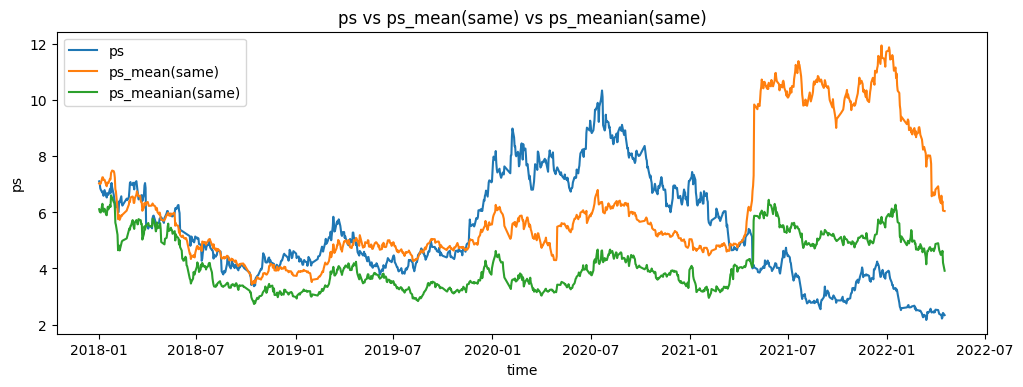

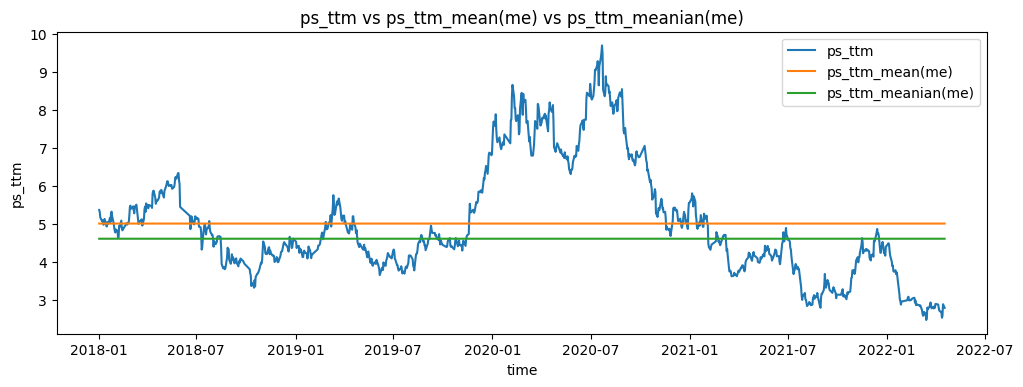

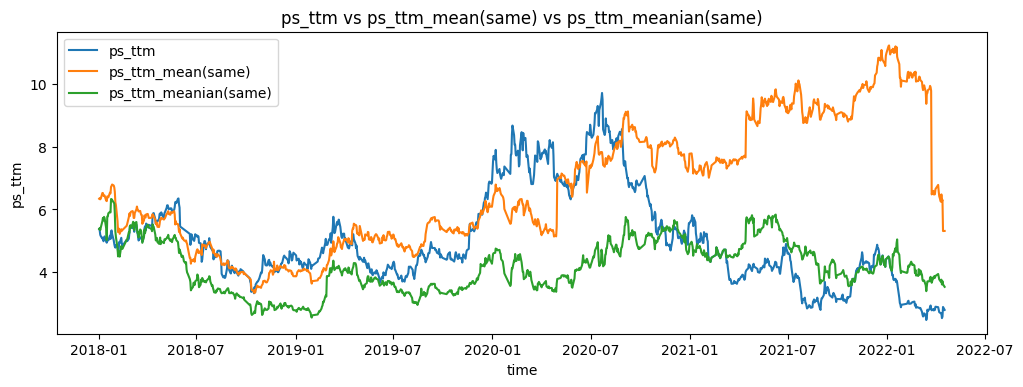

In [94]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

#静态估值
def getRelativeValuation(ts_code):
    same_list='","'.join(getSameList(ts_code))
    same_valuation=mysql.selectToDf('select * from astock_price_daily_basic where ts_code in("'+same_list+'")','tushare')
    same_valuation=same_valuation.fillna(method='ffill')
    same_valuation['pe']=same_valuation['pe'].astype('float')
   
    valuation=mysql.selectToDf('select * from astock_price_daily_basic where ts_code = "'+ts_code+'"','tushare')
    start_date=valuation['trade_date'].values[0]
    valuation=valuation[valuation['trade_date']>="20180101"]
    valuation['trade_date'] = pd.to_datetime(valuation['trade_date'], format='%Y%m%d')
    valuation=valuation.set_index('trade_date')     
    
    v_list=['pe','pe_ttm','pb','ps','ps_ttm']
    
    for v_name in v_list:
        same_valuation[v_name]=same_valuation[v_name].astype('float')
        same_v = same_valuation.groupby('trade_date')[v_name].agg(["mean","median"]).reset_index()
        same_v=same_v[same_v['trade_date']>=start_date]
        same_v=same_v[same_v['trade_date']>="20180101"]
        v=valuation[v_name]
        same_v['trade_date'] = pd.to_datetime(same_v['trade_date'], format='%Y%m%d')
        same_v=same_v.set_index('trade_date')
        v=v.astype(float)
        valuation['v_mean']=v.mean()
        valuation['v_median']=v.median()
        plt.figure(dpi=100,figsize=(12,4))
        plt.title(v_name+" vs "+v_name+"_mean(me) vs "+v_name+"_meanian(me)")
        plt.xlabel("time")
        plt.ylabel(v_name)
        plt.plot(v)
        plt.plot(valuation['v_mean'])
        plt.plot(valuation['v_median'])
        plt.legend([v_name,v_name+'_mean(me)',v_name+'_meanian(me)'])
        plt.show()    
 

        plt.figure(dpi=100,figsize=(12,4))
        plt.title(v_name+" vs "+v_name+"_mean(same) vs "+v_name+"_meanian(same)")
        plt.xlabel("time")
        plt.ylabel(v_name)
        plt.plot(v)
        plt.plot(same_v['mean'])
        plt.plot(same_v['median'])
        plt.legend([v_name,v_name+'_mean(same)',v_name+'_meanian(same)'])
        plt.show()  

    
getRelativeValuation(ts_code)


--------------------roe------------------------------
roe指标：净资产回报率，越高越好【盈利能力】
股票002624.sz的roe指标(蓝色)与其自身的均值(橙色)、中位数(绿色)对比图如下：


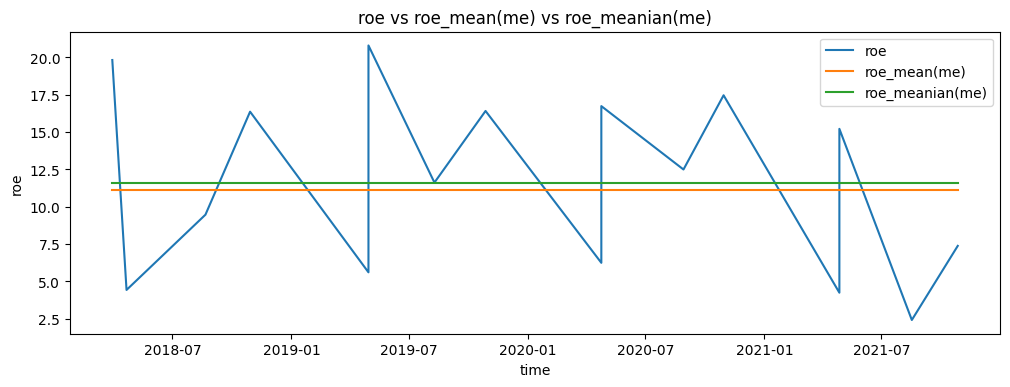

股票002624.sz的roe指标(蓝色)与同行业roe的均值(橙色)、中位数(绿色)对比图如下：


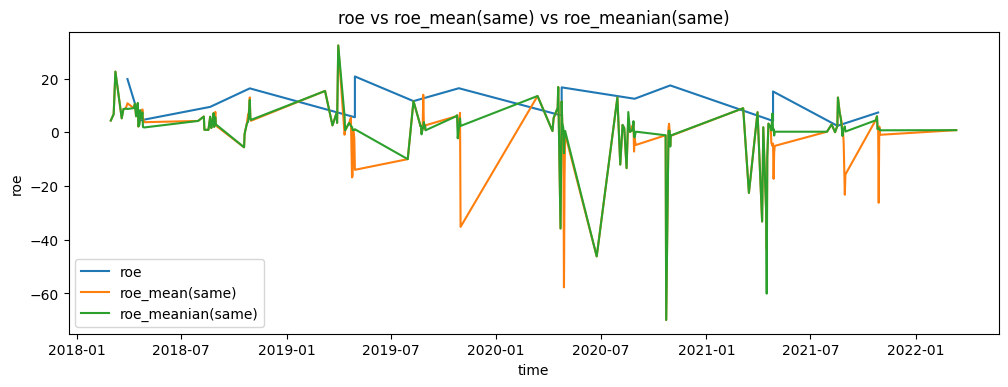


--------------------netprofit_margin------------------------------
netprofit_margin指标：销售净利率，越高越好【盈利能力】
股票002624.sz的netprofit_margin指标(蓝色)与其自身的均值(橙色)、中位数(绿色)对比图如下：


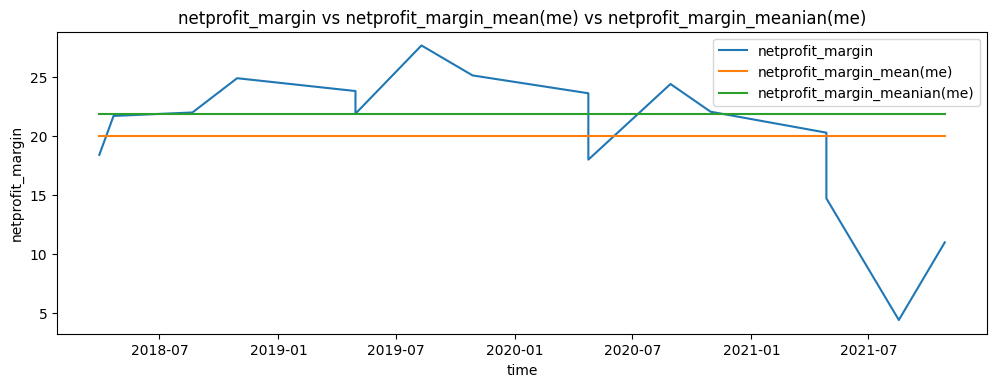

股票002624.sz的netprofit_margin指标(蓝色)与同行业netprofit_margin的均值(橙色)、中位数(绿色)对比图如下：


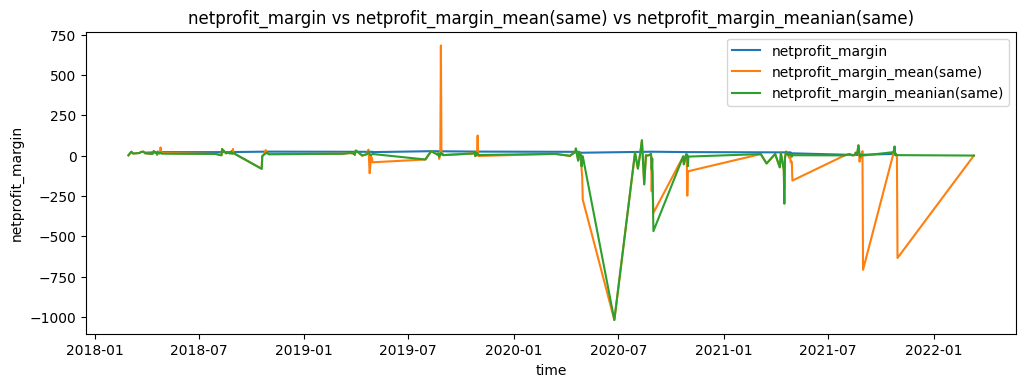


--------------------grossprofit_margin------------------------------
grossprofit_margin指标：销售毛利率，越高越好【盈利能力】
股票002624.sz的grossprofit_margin指标(蓝色)与其自身的均值(橙色)、中位数(绿色)对比图如下：


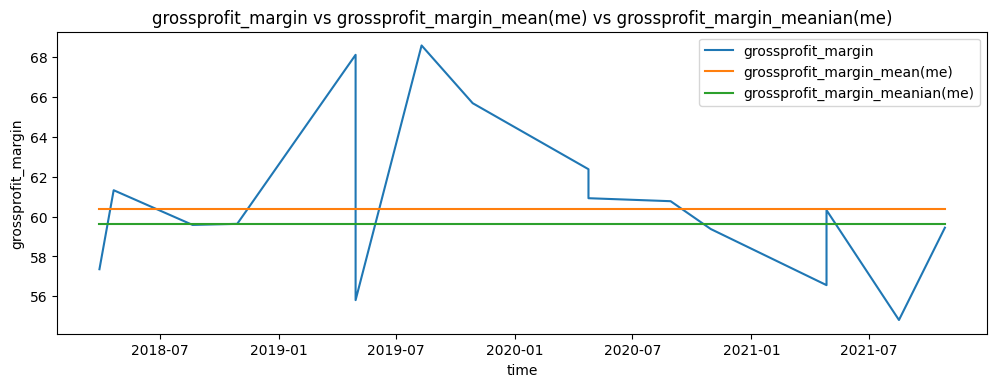

股票002624.sz的grossprofit_margin指标(蓝色)与同行业grossprofit_margin的均值(橙色)、中位数(绿色)对比图如下：


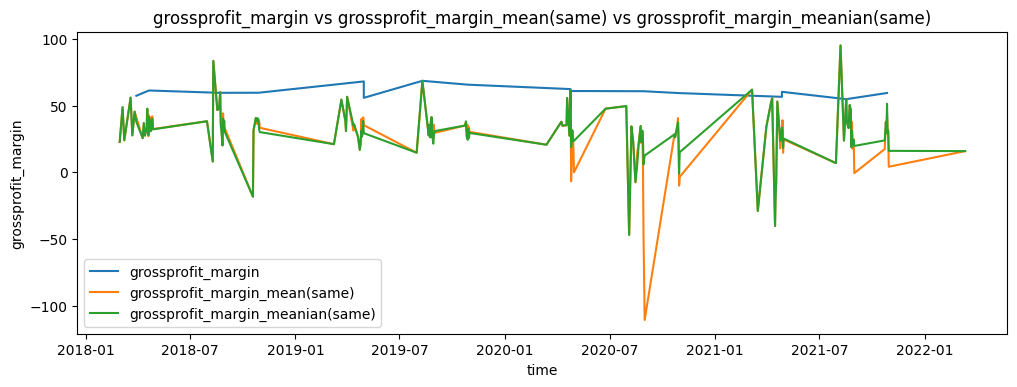


--------------------current_ratio------------------------------
current_ratio指标：流动比率=流动资产÷流动负债，2左右较为合理【短期偿债能力】
股票002624.sz的current_ratio指标(蓝色)与其自身的均值(橙色)、中位数(绿色)对比图如下：


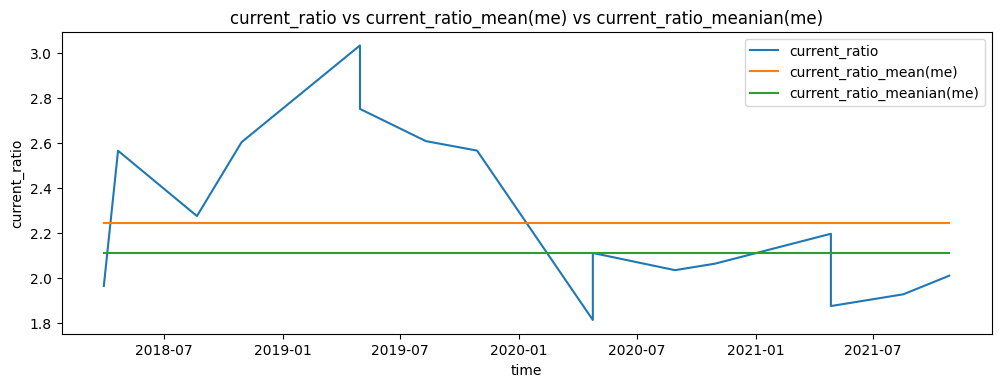

股票002624.sz的current_ratio指标(蓝色)与同行业current_ratio的均值(橙色)、中位数(绿色)对比图如下：


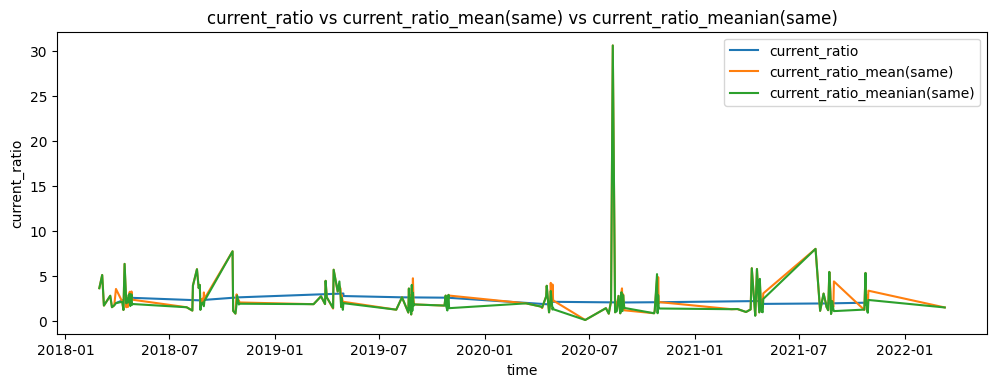


--------------------quick_ratio------------------------------
quick_ratio指标：速动比率=速动资产÷流动负债，1左右较为合理【短期偿债能力】
股票002624.sz的quick_ratio指标(蓝色)与其自身的均值(橙色)、中位数(绿色)对比图如下：


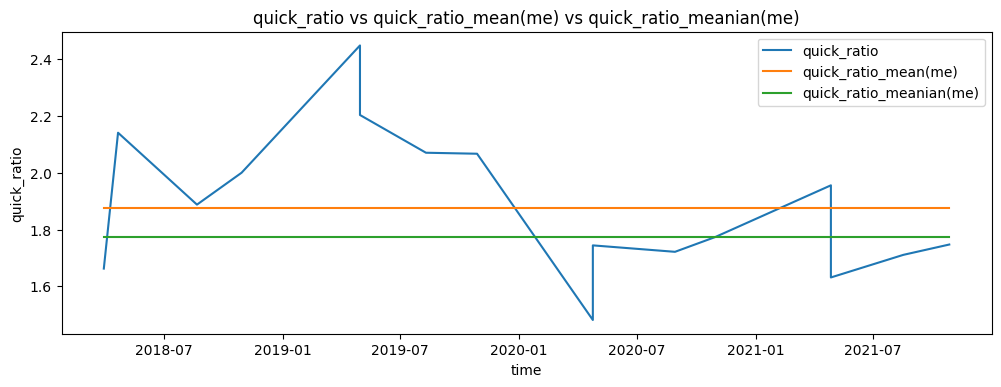

股票002624.sz的quick_ratio指标(蓝色)与同行业quick_ratio的均值(橙色)、中位数(绿色)对比图如下：


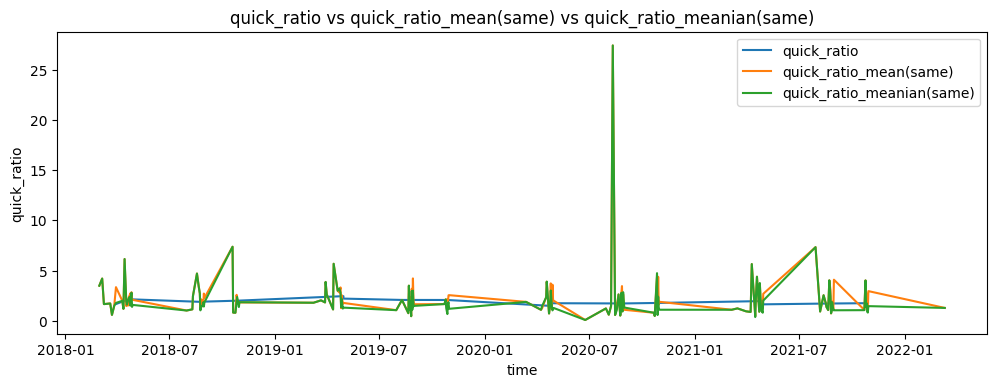


--------------------debt_to_assets------------------------------
debt_to_assets指标：资产负债率=(负债总额÷资产总额)×100%，越低越好【长期偿债能力】
股票002624.sz的debt_to_assets指标(蓝色)与其自身的均值(橙色)、中位数(绿色)对比图如下：


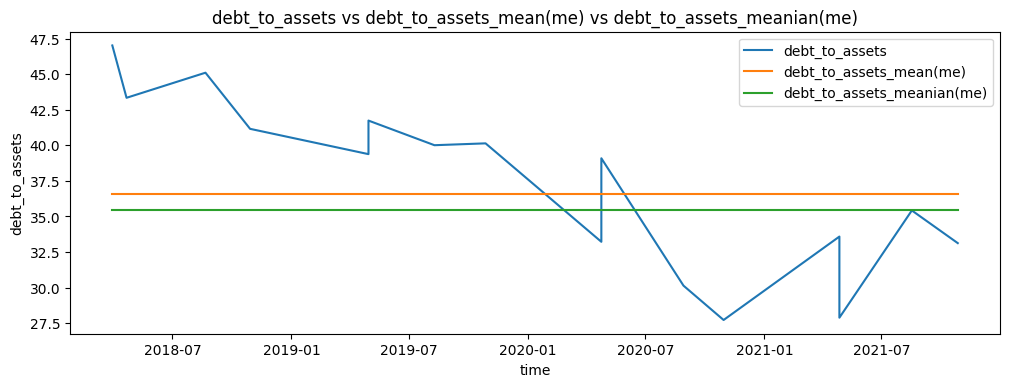

股票002624.sz的debt_to_assets指标(蓝色)与同行业debt_to_assets的均值(橙色)、中位数(绿色)对比图如下：


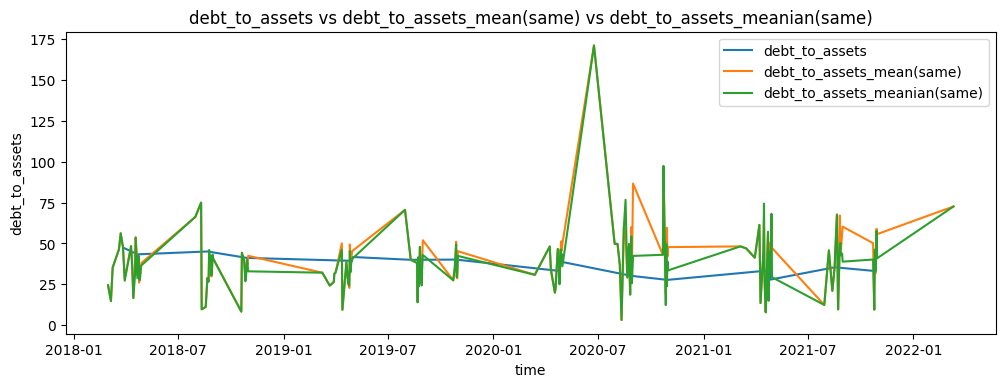


--------------------ar_turn------------------------------
ar_turn指标：应收账款周转率，越高越好【营运能力】
股票002624.sz的ar_turn指标(蓝色)与其自身的均值(橙色)、中位数(绿色)对比图如下：


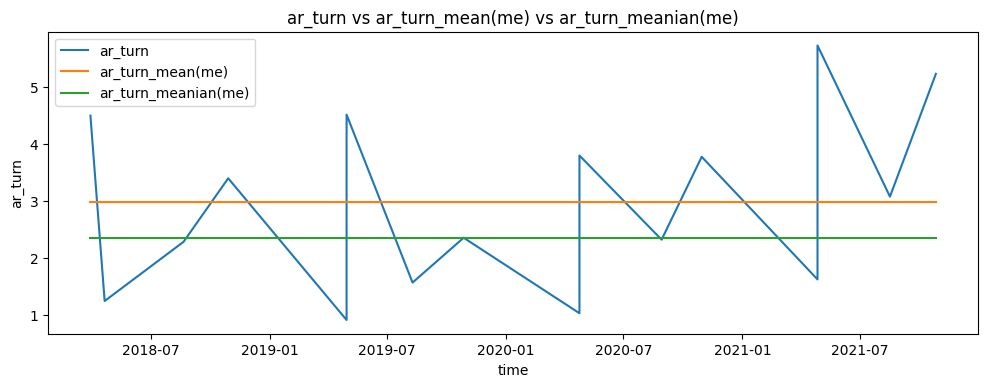

股票002624.sz的ar_turn指标(蓝色)与同行业ar_turn的均值(橙色)、中位数(绿色)对比图如下：


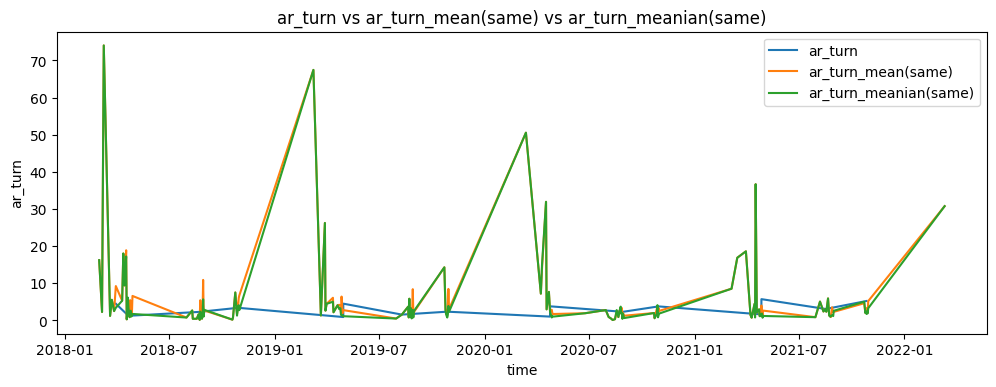


--------------------ca_turn------------------------------
ca_turn指标：流动资产周转率，越高越好【营运能力】
股票002624.sz的ca_turn指标(蓝色)与其自身的均值(橙色)、中位数(绿色)对比图如下：


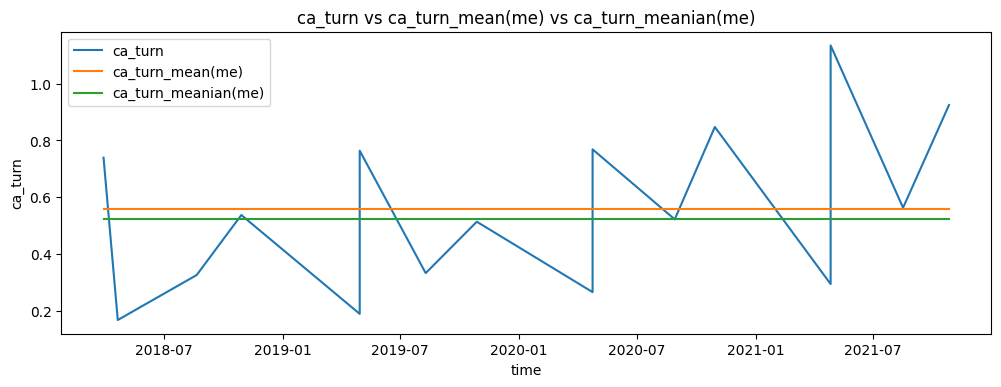

股票002624.sz的ca_turn指标(蓝色)与同行业ca_turn的均值(橙色)、中位数(绿色)对比图如下：


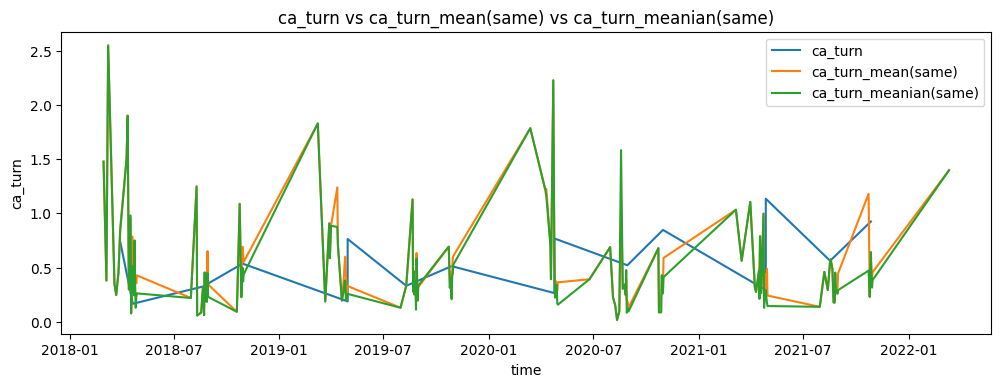


--------------------fa_turn------------------------------
fa_turn指标：固定资产周转率，越高越好【营运能力】
股票002624.sz的fa_turn指标(蓝色)与其自身的均值(橙色)、中位数(绿色)对比图如下：


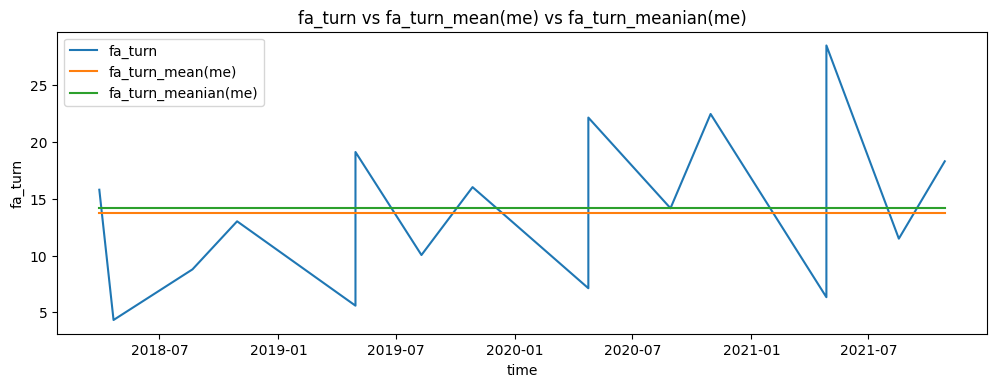

股票002624.sz的fa_turn指标(蓝色)与同行业fa_turn的均值(橙色)、中位数(绿色)对比图如下：


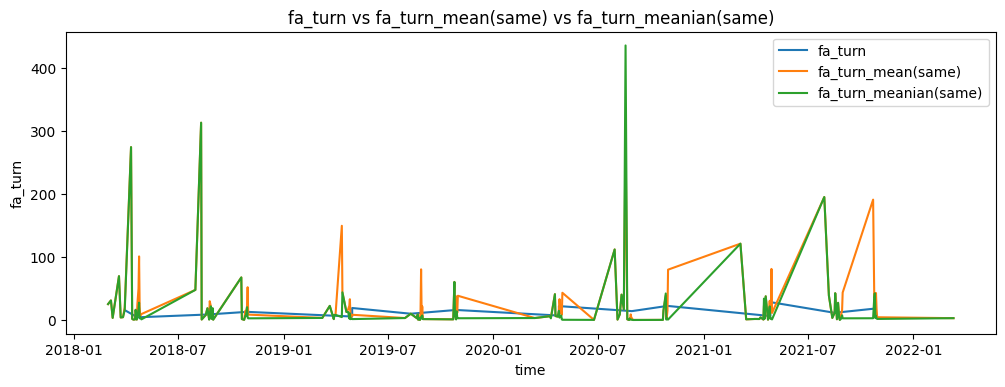


--------------------assets_turn------------------------------
assets_turn指标：总资产周转率，越高越好【营运能力】
股票002624.sz的assets_turn指标(蓝色)与其自身的均值(橙色)、中位数(绿色)对比图如下：


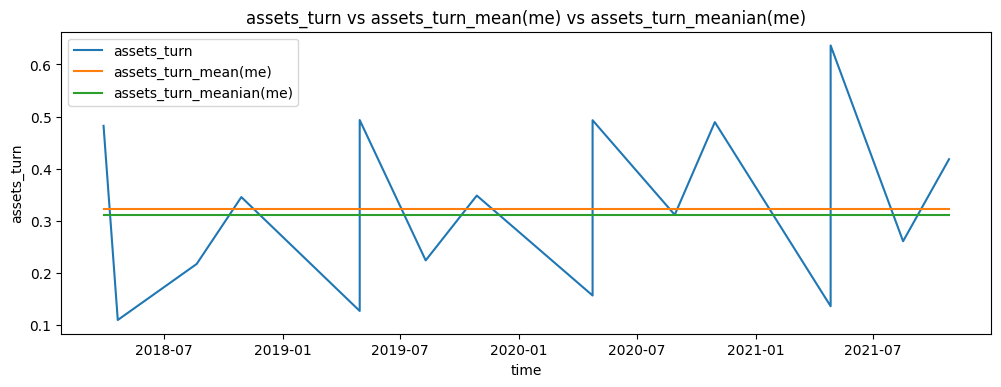

股票002624.sz的assets_turn指标(蓝色)与同行业assets_turn的均值(橙色)、中位数(绿色)对比图如下：


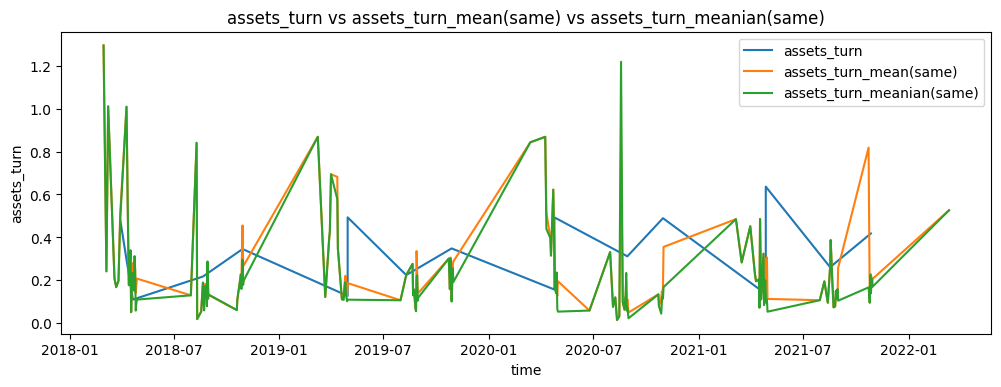

In [133]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

#财务指标


def getFinanceIndicator(ts_code):
    same_list='","'.join(getSameList(ts_code))
    same_indicator=mysql.selectToDf('select * from astock_finance_indicator where ts_code in("'+same_list+'")  order by ann_date asc','tushare')
    same_indicator=same_indicator.fillna(method='ffill')
 

    indicator=mysql.selectToDf('select * from astock_finance_indicator where ts_code = "'+ts_code+'" order by ann_date asc','tushare')
    start_date=indicator['ann_date'].values[0]
    df_align=indicator['ann_date']
    indicator=indicator[indicator['ann_date']>="20180101"]
    indicator['ann_date'] = pd.to_datetime(indicator['ann_date'], format='%Y%m%d')
    
    indicator=indicator.set_index('ann_date')     
    
    
    i_list={
        'roe':'净资产回报率，越高越好【盈利能力】',
        'netprofit_margin':'销售净利率，越高越好【盈利能力】',
        'grossprofit_margin':'销售毛利率，越高越好【盈利能力】',
        'current_ratio':'流动比率=流动资产÷流动负债，2左右较为合理【短期偿债能力】',
        'quick_ratio':'速动比率=速动资产÷流动负债，1左右较为合理【短期偿债能力】',
        'debt_to_assets':'资产负债率=(负债总额÷资产总额)×100%，越低越好【长期偿债能力】',
        'ar_turn':'应收账款周转率，越高越好【营运能力】',
        'ca_turn':'流动资产周转率，越高越好【营运能力】',
        'fa_turn':'固定资产周转率，越高越好【营运能力】',
        'assets_turn':'总资产周转率，越高越好【营运能力】',
        
    }
    for i_name,i_descr in i_list.items():
        same_indicator[i_name]=same_indicator[i_name].astype('float')
        same_i = same_indicator.groupby('ann_date')[i_name].agg(["mean","median"]).reset_index()
        
 
        same_i=same_i[same_i['ann_date']>=start_date]
        same_i=same_i[same_i['ann_date']>="20180101"]
        
        
        
        v=indicator[i_name]
        same_i['ann_date'] = pd.to_datetime(same_i['ann_date'], format='%Y%m%d')
        same_i=same_i.set_index('ann_date')
        
        
        print("\n--------------------"+i_name+"------------------------------")
        print(""+i_name+"指标："+i_descr)
        print("股票"+ts_code+"的"+i_name+"指标(蓝色)与其自身的均值(橙色)、中位数(绿色)对比图如下：")
        v=v.astype(float)
        indicator['v_mean']=v.mean()
        indicator['v_median']=v.median()
        plt.figure(dpi=100,figsize=(12,4))
        plt.title(i_name+" vs "+i_name+"_mean(me) vs "+i_name+"_meanian(me)")
        plt.xlabel("time")
        plt.ylabel(i_name)
        plt.plot(v)
        plt.plot(indicator['v_mean'])
        plt.plot(indicator['v_median'])
        plt.legend([i_name,i_name+'_mean(me)',i_name+'_meanian(me)'])
        plt.show()    
 
        print("股票"+ts_code+"的"+i_name+"指标(蓝色)与同行业"+i_name+"的均值(橙色)、中位数(绿色)对比图如下：")
        plt.figure(dpi=100,figsize=(12,4))
        plt.title(i_name+" vs "+i_name+"_mean(same) vs "+i_name+"_meanian(same)")
        plt.xlabel("time")
        plt.ylabel(i_name)
        plt.plot(v)
        plt.plot(same_i['mean'])
        plt.plot(same_i['median'])
        plt.legend([i_name,i_name+'_mean(same)',i_name+'_meanian(same)'])
        plt.show()  

    
getFinanceIndicator(ts_code)

In [139]:
from IPython.display import IFrame
IFrame('https://finhack.cn/value/calc?code='+ts_code, width=1000, height=1500)